In [1]:
#Cargar Librerías
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import csv
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('fast')

from sklearn.metrics import r2_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
#SACAR R2 ENTRE VALOR PREDIJO (EL MAS CERCANO, EL MÍNIMO) VS REAL
#AGREGAR VARIABLE "MARCA" AGRUPANDO CON LOS MÁS SIGINFICATIVOS Y "OTROS"

In [3]:
#Cargar archivo .CSV con datos de delitos
#Si es necesario, aún no se puede agregar más variables

df = pd.read_csv("/Users/j.artigasalegra/Documents/tesis/Solicitud_Base_Datos/Base_Dato_Con_Coorednadas/DATOS GEOCODIFICADOS/BASE_DATOS_2014_RED.csv",  parse_dates=[0], index_col=0, names=['Delito', 'DiaSem', 'Mes', 'Hora', 'TipoV','Marca', 'Comuna', 'Longitud', 'Latitud'])
df.head(10)

,DiaSem,Mes,Hora,TipoV,Marca,Comuna,Longitud,Latitud
Delito,,,,,,,,
1,3,1,1,2,2,5,-71.364279,-33.066009
2,3,1,4,1,13,12,-71.449283,-32.506328
3,3,1,5,1,1,2,-71.244152,-32.885247
4,3,1,5,4,17,1,-71.544414,-32.958467
5,3,1,6,1,2,4,-71.607311,-33.564088
6,3,1,8,1,5,1,-71.546929,-33.022157
7,3,1,9,3,3,2,-71.586060,-33.033630
8,3,1,11,5,10,3,-71.334306,-33.152032
9,3,1,13,1,2,1,-71.578250,-33.030275


In [4]:
df.describe()

,DiaSem,Mes,Hora,TipoV,Marca,Comuna,Longitud,Latitud
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000
mean,3.956557,6.169262,12.381148,2.061885,6.955738,3.791393,-71.612225,-32.998425
std,1.972483,3.378725,7.380413,1.604838,6.059539,3.498188,2.668238,0.460287
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-109.436278,-33.921019
25%,2.000000,3.000000,6.000000,1.000000,2.000000,1.000000,-71.559836,-33.049016
50%,4.000000,6.000000,12.000000,1.000000,4.000000,2.000000,-71.518119,-33.028333
75%,6.000000,9.000000,20.000000,3.000000,12.000000,5.000000,-71.395749,-32.975777
max,7.000000,12.000000,23.000000,6.000000,17.000000,12.000000,-70.182509,-27.073739


In [5]:
# convertir series a aprendizaje supervizado
#Aprendizaje supervisado será utilizando los 15 días previos para predecir el actual delito (latitud y longitud)

def series_to_supervised(data, n_in=1, n_out=2, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
PASOS = 15

data = df.values
data = data.astype('float32')
scaler = MinMaxScaler()
data = scaler.fit_transform(data[:, :8])
data = pd.DataFrame(data)
data.columns = data.columns
data=data.rename(columns = {0:'Diasem', 1:'Mes', 2:'Hora', 3:'TipoV', 4:'Marca', 5:'Comuna', 6:'Longitud', 7:'Latitud'})
data.head()

scaledMerge= data

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
print(reframed.shape)
reframed.head()

(2425, 128)


,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var7(t-15),var8(t-15),var1(t-14),var2(t-14),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
15,0.333333,0.0,0.043478,0.2,0.0625,0.363636,0.969894,0.124869,0.333333,0.0,...,0.964846,0.131588,0.666667,0.0,0.782609,0.0,0.4375,0.454545,0.965257,0.144309
16,0.333333,0.0,0.173913,0.0,0.7500,1.000000,0.967729,0.206606,0.333333,0.0,...,0.965257,0.144309,0.666667,0.0,0.782609,0.0,0.1250,0.090909,0.972954,0.151268
17,0.333333,0.0,0.217391,0.0,0.0000,0.090909,0.972954,0.151268,0.333333,0.0,...,0.972954,0.151268,0.666667,0.0,0.913043,0.0,0.0625,0.000000,0.965098,0.132321
18,0.333333,0.0,0.217391,0.6,1.0000,0.000000,0.965305,0.140575,0.333333,0.0,...,0.965098,0.132321,0.666667,0.0,0.956522,0.0,0.3750,0.090909,0.963761,0.053650
19,0.333333,0.0,0.260870,0.0,0.0625,0.272727,0.963703,0.052128,0.333333,0.0,...,0.963761,0.053650,0.666667,0.0,0.956522,1.0,1.0000,0.000000,0.967033,0.134938


In [7]:
#Se elimina las otras variables en perido t para solo tener como salida Longitud y Latitud

newReframed=reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var4(t)', 'var5(t)', 'var6(t)'])
print(newReframed.shape)
newReframed.head()

(2425, 122)


,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var7(t-15),var8(t-15),var1(t-14),var2(t-14),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var7(t),var8(t)
15,0.333333,0.0,0.043478,0.2,0.0625,0.363636,0.969894,0.124869,0.333333,0.0,...,0.666667,0.0,0.434783,0.0,0.3125,0.000000,0.964846,0.131588,0.965257,0.144309
16,0.333333,0.0,0.173913,0.0,0.7500,1.000000,0.967729,0.206606,0.333333,0.0,...,0.666667,0.0,0.782609,0.0,0.4375,0.454545,0.965257,0.144309,0.972954,0.151268
17,0.333333,0.0,0.217391,0.0,0.0000,0.090909,0.972954,0.151268,0.333333,0.0,...,0.666667,0.0,0.782609,0.0,0.1250,0.090909,0.972954,0.151268,0.965098,0.132321
18,0.333333,0.0,0.217391,0.6,1.0000,0.000000,0.965305,0.140575,0.333333,0.0,...,0.666667,0.0,0.913043,0.0,0.0625,0.000000,0.965098,0.132321,0.963761,0.053650
19,0.333333,0.0,0.260870,0.0,0.0625,0.272727,0.963703,0.052128,0.333333,0.0,...,0.666667,0.0,0.956522,0.0,0.3750,0.090909,0.963761,0.053650,0.967033,0.134938


In [8]:
#Separar datos como datos de entrenamiento y datos de prueba 
#Separa los datos en 70% (1700) train y 30% (725) validación

values = newReframed.values
train = values[0:1700, :]
test = values[1700:2426, :]

# split into input and outputs

x_train, y_train = train[:, 0:120], train[:, 120:122]
x_val, y_val = test[:, 0:120], test[:, 120:122]

# reshape input to be 3D [samples, timesteps, features]
#x_train = x_train.reshape((x_train.shape[0], 1,x_train.shape[1]))
#x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1700, 120) (1700, 2) (725, 120) (725, 2)


In [9]:
#Se define la red neuronal, cuando tenga la red lista, probare con distintas funciones de activación o nodos

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(120, input_dim=(120), kernel_initializer='normal',activation='sigmoid'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [10]:
#Despues de tener lista la red, variare EPOCHS para ver como mejoran los resultados
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               14520     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 242       
Total params: 14,762
Trainable params: 14,762
Non-trainable params: 0
_________________________________________________________________
Train on 1700 samples, validate on 725 samples
Epoch 1/40
1700/1700 [==============================] - 3s 2ms/sample - loss: 0.0188 - mse: 0.0045 - val_loss: 0.0183 - val_mse: 0.0074
Epoch 2/40
1700/1700 [==============================] - 3s 2ms/sample - loss: 0.0150 - mse: 0.0035 - val_loss: 0.0188 - val_mse: 0.0073
Epoch 3/40
1700/1700 [==============================] - 3s 2ms/sample - loss: 0.0147 - mse: 0.0035 - val_loss: 0.0184 - val_mse: 0.0073
Epoch 4/40
1700/1700 [==============================] - 3s 

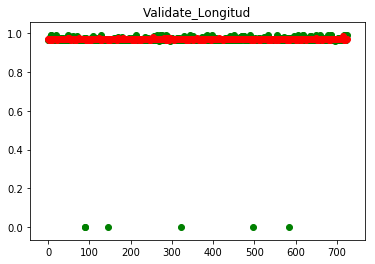

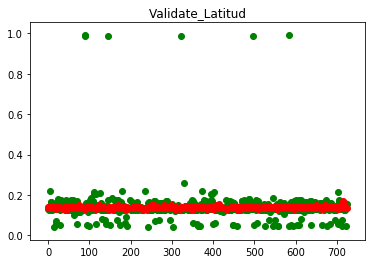

In [11]:
#Renombrar columnas de variable predicha y validación

results=model.predict(x_val)
results = pd.DataFrame(results)
results.columns = results.columns
results=results.rename(columns = {0:'Longitud', 1:'Latitud'})
#print(results)

y_val = pd.DataFrame(y_val)
y_val.columns = y_val.columns
y_val=y_val.rename(columns = {0:'Longitud', 1:'Latitud'})
#print(y_val)

#Permite visualizar que tanto se acerca la predicción con los valores de validación
plt.scatter(range(len(y_val['Longitud'])),y_val['Longitud'],c='g')
plt.scatter(range(len(results['Longitud'])),results['Longitud'],c='r')
plt.title('Validate_Longitud')
plt.show()

plt.scatter(range(len(y_val['Latitud'])),y_val['Latitud'],c='g')
plt.scatter(range(len(results['Latitud'])),results['Latitud'],c='r')
plt.title('Validate_Latitud')
plt.show()

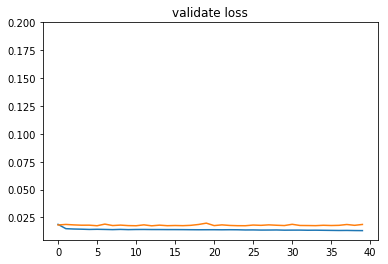

In [12]:
#Permite graficar la pérdida LOSS tanto del conjunto de ENTENAMIENTO(azul)  como de VALIDACION(naranja)

plt.ylim(0.005, 0.2)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

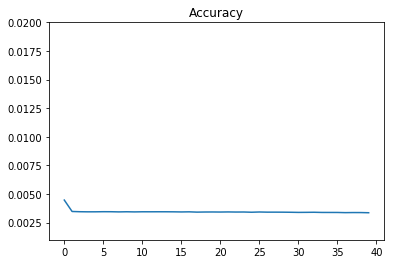

In [13]:
plt.ylim(0.001, 0.02)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [14]:
#Agregar 4 columnas falsasa para poder invertir valores a original

results['Var3'] = results['Longitud']
results['Var4'] = results['Longitud']
results['Var5'] = results['Longitud']
results['Var6'] = results['Latitud']
results['Var7'] = results['Longitud']
results['Var8'] = results['Latitud']
print(results)

y_val['Var3'] = y_val["Latitud"]
y_val['Var4'] = y_val["Latitud"]
y_val['Var5'] = y_val["Longitud"]
y_val['Var6'] = y_val["Latitud"]
y_val['Var7'] = y_val["Longitud"]
y_val['Var8'] = y_val["Latitud"]
print(y_val)

     Longitud   Latitud      Var3      Var4      Var5      Var6      Var7  \
0    0.969743  0.141837  0.969743  0.969743  0.969743  0.141837  0.969743   
1    0.967475  0.136696  0.967475  0.967475  0.967475  0.136696  0.967475   
2    0.966861  0.135925  0.966861  0.966861  0.966861  0.135925  0.966861   
3    0.965564  0.132586  0.965564  0.965564  0.965564  0.132586  0.965564   
4    0.970755  0.139287  0.970755  0.970755  0.970755  0.139287  0.970755   
5    0.965714  0.136955  0.965714  0.965714  0.965714  0.136955  0.965714   
6    0.968725  0.140398  0.968725  0.968725  0.968725  0.140398  0.968725   
7    0.967902  0.137445  0.967902  0.967902  0.967902  0.137445  0.967902   
8    0.967692  0.134384  0.967692  0.967692  0.967692  0.134384  0.967692   
9    0.969164  0.135502  0.969164  0.969164  0.969164  0.135502  0.969164   
10   0.966525  0.137154  0.966525  0.966525  0.966525  0.137154  0.966525   
11   0.967299  0.133203  0.967299  0.967299  0.967299  0.133203  0.967299   

In [15]:
#Primero se inviernten los valores de "y_val" y "results" a su valor original
inverted_res = scaler.inverse_transform(results.values)
compara_res = pd.DataFrame(inverted_res)

inverted_y_val = scaler.inverse_transform(y_val.values)
compara_y_val = pd.DataFrame(inverted_y_val)

#Segundo se asgina nombre a las columnas de cada variable
compara_y_val=compara_y_val.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Longitud', 7:'Latitud'})
compara_res=compara_res.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Longitud', 7:'Latitud'})

#Tercero se eliminan las variables no necesarias
compara_res = compara_res.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
compara_y_val = compara_y_val.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
#print(compara_y_val)
#print(compara_res)

#Cuarto crea variable "diferencia" entre valores de resultado y validación, tanto para longitud como latitud
diferencia_lon = compara_res['Longitud'] - compara_y_val['Longitud']
diferencia_lat  = compara_res['Latitud'] - compara_y_val['Latitud']
print(diferencia_lon)
print(diferencia_lat)

0      0.197166
1     -0.020668
2      0.052917
3     -0.052574
4      0.206970
5     -0.460594
6     -0.758247
7     -0.790550
8      0.090919
9     -0.700226
10    -0.074181
11     0.137329
12     0.129875
13    -0.171730
14    -0.020309
15     0.172478
16     0.097908
17     0.099594
18     0.137115
19     0.183868
20    -0.882835
21     0.094330
22    -0.000229
23    -0.266914
24    -0.215004
25     0.108177
26     0.158241
27    -0.081108
28     0.147964
29     0.158485
         ...   
695    0.318848
696    0.122284
697    0.205132
698    0.102310
699    0.101112
700    0.089035
701   -0.030663
702    0.063644
703    0.141373
704   -0.177773
705    0.054131
706   -0.204269
707    0.062309
708   -0.218567
709    0.076324
710    0.073311
711    0.100510
712    0.359444
713    0.178650
714    0.050667
715    0.733482
716    0.390327
717   -0.102448
718   -0.784653
719   -0.779945
720   -0.150734
721   -0.331459
722   -0.244789
723    0.146545
724   -0.890160
Name: Longitud, Length: 

In [16]:
r2_score(compara_y_val, compara_res, multioutput='variance_weighted')

-0.006017221643354824

In [17]:
r2_score(compara_y_val['Longitud'], compara_res['Longitud'])

-0.005915881519475752

In [18]:
r2_score(compara_y_val['Latitud'], compara_res['Latitud'])

-0.009776258680212813

In [19]:
#Compara Longitudes reales, predichos y su diferencia.
compara_lon = pd.DataFrame(np.array([compara_y_val['Longitud'], compara_res['Longitud']])).transpose()
compara_lon.columns = ['real', 'prediccion']

compara_lon2 = pd.DataFrame(compara_lon)
compara_lon2.columns = ['real', 'prediccion']
compara_lon2['diferencia'] = diferencia_lon
compara_lon2.head(10)

,real,prediccion,diferencia
0,-71.567383,-71.370216,0.197166
1,-71.438568,-71.459236,-0.020668
2,-71.536247,-71.483330,0.052917
3,-71.481674,-71.534248,-0.052574
4,-71.537468,-71.330498,0.206970
5,-71.067757,-71.528351,-0.460594
6,-70.651939,-71.410187,-0.758247
7,-70.651939,-71.442490,-0.790550
8,-71.541656,-71.450737,0.090919
9,-70.692726,-71.392952,-0.700226


In [20]:
#Compara Latitudes reales, predichos y su diferencia.
compara_lat = pd.DataFrame(np.array([compara_y_val['Latitud'], compara_res['Latitud']])).transpose()
compara_lat.columns = ['real', 'prediccion']

compara_lat2 = pd.DataFrame(compara_lat)
compara_lat2.columns = ['real', 'prediccion']
compara_lat2['diferencia'] = diferencia_lat
compara_lat2.head(4)

,real,prediccion,diferencia
0,-33.030678,-32.949821,0.080856
1,-33.054306,-32.985023,0.069283
2,-32.980659,-32.990303,-0.009644
3,-33.030792,-33.013165,0.017628


In [21]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lon = pd.DataFrame(compara_lon2)
prediccion_lon.to_csv('M6_pronostico_longitud.csv')

In [22]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lat = pd.DataFrame(compara_lat2)
prediccion_lat.to_csv('M6_pronostico_latitud.csv')

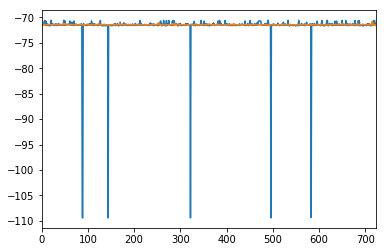

In [23]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Longitud del delito"

compara_lon['real'].plot() #Color azul
compara_lon['prediccion'].plot() #Color naranjo

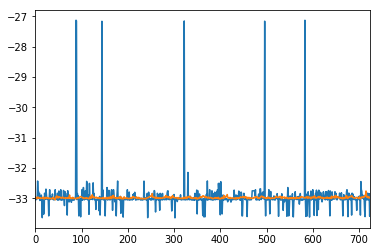

In [24]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Latitud del delito"

compara_lat['real'].plot() #Color azul
compara_lat['prediccion'].plot() #Color naranjo